<a href="https://colab.research.google.com/github/wahid028/CryptoCurrency-Price-prediction_Kaggle/blob/main/LGBM_Regressor_g_research_crypto_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#install kaggle
!pip install -q kaggle

In [ ]:
#upload the kaggle.json file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"learn2know","key":"ef7c1f3683ce0590f0cee38b88d74d21"}'}

In [ ]:
#create a kaggle directory
!mkdir ~/.kaggle

In [ ]:
#copy the kaggle.json to kaggle directory
!cp kaggle.json ~/.kaggle/

In [ ]:
#permission for the json to act
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#list all the available dataset in kaggle
!kaggle datasets list

ref                                                                   title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
muratkokludataset/date-fruit-datasets                                 Date Fruit Datasets                              408KB  2022-04-03 09:25:39           8117       1089  0.9375           
victorsoeiro/netflix-tv-shows-and-movies                              Netflix TV Shows and Movies                        2MB  2022-05-15 00:01:23            653         30  0.9411765        
mdmahmudulhasansuzan/students-adaptability-level-in-online-education  Students Adaptability Level in Online Education    6KB  2022-04-16 04:46:28           5467        137  1.0              
muratkokludataset/rice-image-dataset         

## **Dataset**

In [ ]:
!kaggle competitions download -c g-research-crypto-forecasting

100% 1.13G/1.13G [00:08<00:00, 122MB/s] 
100% 1.13G/1.13G [00:08<00:00, 144MB/s]


In [ ]:
!unzip g-research-crypto-forecasting.zip

Archive:  g-research-crypto-forecasting.zip
  inflating: asset_details.csv       
  inflating: example_sample_submission.csv  
  inflating: example_test.csv        
  inflating: gresearch_crypto/__init__.py  
  inflating: gresearch_crypto/competition.cpython-37m-x86_64-linux-gnu.so  
  inflating: supplemental_train.csv  
  inflating: train.csv               


In [ ]:
!pip install datatable

     |████████████████████████████████| 96.9 MB 109 kB/s 


## **Bitcoin Crash Prediction_LGBMRegressor**

In [ ]:
#mporting Required Libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly
import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from lightgbm import LGBMRegressor

In [ ]:
def reduce_memory_usage(df):
    """ 
    iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
#     start_mem = df.memory_usage().sum() / 1024**2
#     print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))    

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
#     print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
#     print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [ ]:
data = pd.read_csv('../content/train.csv')
data.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


In [ ]:
asset_id = pd.read_csv('../content/asset_details.csv')
asset = asset_id.set_index('Asset_ID').sort_index()
asset

,Weight,Asset_Name
Asset_ID,,
0,4.304065,Binance Coin
1,6.779922,Bitcoin
2,2.397895,Bitcoin Cash
3,4.406719,Cardano
4,3.555348,Dogecoin
5,1.386294,EOS.IO
6,5.894403,Ethereum
7,2.079442,Ethereum Classic
8,1.098612,IOTA


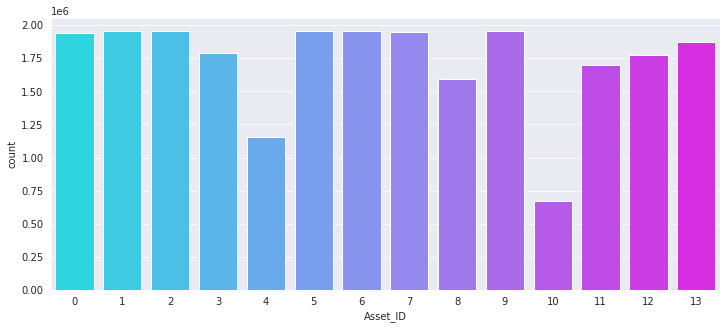

In [ ]:
plt.figure(figsize=(12,5))
sns.countplot(data['Asset_ID'], palette='cool');

In [ ]:
#Let's have a look at the most famous crypto - BITCOIN
btc = data[data['Asset_ID'] == 1].set_index("timestamp")
btc_range = btc.iloc[-500:]  # Since we cannot plot the entire btc, so selecting the latest 500 points.
btc_range.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
1632152460,1,1747.0,43795.582857,43812.350001,43757.74,43788.523087,57.418939,43779.265159,-0.000782
1632152520,1,2004.0,43789.091429,43856.000000,43774.50,43795.514286,70.487479,43805.173544,-0.000468
1632152580,1,1792.0,43788.650000,43868.000000,43754.55,43844.012857,63.508808,43804.801217,-0.000810
1632152640,1,1822.0,43841.212857,43868.000000,43759.70,43776.195714,66.363434,43795.941803,-0.000596
1632152700,1,1741.0,43773.905714,43851.000000,43742.91,43825.920000,50.774907,43790.736873,-0.001321


In [ ]:
fig = go.Figure(data=[go.Candlestick(x=btc_range.index, 
                                     open=btc_range['Open'], 
                                     high=btc_range['High'], 
                                     low=btc_range['Low'], 
                                     close=btc_range['Close'])])
print('Use the slider to Adjust and Zoom')
fig.show()

Use the slider to Adjust and Zoom


In [ ]:
#Let's have a look at another crypto - ETHEREUM
eth = data[data['Asset_ID'] == 1].set_index("timestamp")
eth_range = eth.iloc[-500:]  # Since we cannot plot the entire btc, so selecting the latest 500 points.


fig = go.Figure(data=[go.Candlestick(x=eth_range.index, 
                                     open=eth_range['Open'], 
                                     high=eth_range['High'], 
                                     low=eth_range['Low'], 
                                     close=eth_range['Close'])])
fig.show()

**Data Preprocessing**

In [ ]:
data.isnull().sum()

timestamp         0
Asset_ID          0
Count             0
Open              0
High              0
Low               0
Close             0
Volume            0
VWAP              9
Target       750338
dtype: int64

In [ ]:
btc.isnull().sum()

Asset_ID      0
Count         0
Open          0
High          0
Low           0
Close         0
Volume        0
VWAP          0
Target      304
dtype: int64

Missing asset data, for a given minute, is not represented by NaN's, but instead by the absence of those rows. We can check the timestamp difference between consecutive rows to see if there is missing data.

In [ ]:
(btc.index[1:]-btc.index[:-1]).value_counts().head()

60     1956136
120         78
180         12
240         11
420          9
Name: timestamp, dtype: int64

Notice that there are many gaps in the data.

Let's now see Ethereum.

In [ ]:
eth.isnull().sum()

Asset_ID      0
Count         0
Open          0
High          0
Low           0
Close         0
Volume        0
VWAP          0
Target      304
dtype: int64

In [ ]:
(eth.index[1:]-eth.index[:-1]).value_counts().head()

60     1956136
120         78
180         12
240         11
420          9
Name: timestamp, dtype: int64

As expected it also has large gaps.

To work with most time series models, we should preprocess our data into a format without time gaps.

To fill the gaps, we can use the .reindex() method for forward filling, filling gaps with the previous valid value.

In [ ]:
btc = btc.reindex(range(btc.index[0],btc.index[-1]+60,60),method='pad')
eth = eth.reindex(range(eth.index[0],eth.index[-1]+60,60),method='pad')

In [ ]:
(btc.index[1:]-btc.index[:-1]).value_counts().head()
(eth.index[1:]-eth.index[:-1]).value_counts().head()

60    1956959
Name: timestamp, dtype: int64

Clearly, their is no time gap now.

**Feature Enginnering**

In [ ]:
def upper_shadow(df):
    return df["High"] - np.maximum(df["Close"], df["Open"])

def lower_shadow(df):
    return np.minimum(df["Close"], df["Open"]) - df["Low"]

In [ ]:
def get_features(dataframe, row=False):
    df_feat = dataframe.copy()
    
    df_feat["Upper_Shadow"] = upper_shadow(df_feat)
    df_feat["Lower_Shadow"] = lower_shadow(df_feat)

    ## Adding some more features
    df_feat["Close/Open"] = df_feat["Close"] / df_feat["Open"] 
    df_feat["Close-Open"] = df_feat["Close"] - df_feat["Open"] 
    df_feat["High-Low"] = df_feat["High"] - df_feat["Low"] 
    df_feat["High/Low"] = df_feat["High"] / df_feat["Low"]
    
    if row:
        df_feat['Mean'] = df_feat[['Open', 'High', 'Low', 'Close']].mean()
    else:
        df_feat['Mean'] = df_feat[['Open', 'High', 'Low', 'Close']].mean(axis=1)

    df_feat["High/Mean"] = df_feat["High"] / df_feat["Mean"]
    df_feat["Low/Mean"] = df_feat["Low"] / df_feat["Mean"]
    df_feat["Volume/Count"] = df_feat["Volume"] / (df_feat["Count"] + 1)

    times = pd.to_datetime(df_feat["timestamp"],unit="s",infer_datetime_format=True)
    if row:
        df_feat["hour"] = times.hour  # .dt
        df_feat["dayofweek"] = times.dayofweek 
        df_feat["day"] = times.day 
    else:
        df_feat["hour"] = times.dt.hour  # .dt
        df_feat["dayofweek"] = times.dt.dayofweek 
        df_feat["day"] = times.dt.day 
    
    if row:
        df_feat["Median"] = df_feat[["Open", "High", "Low", "Close"]].median()
    else:
        df_feat["Median"] = df_feat[["Open", "High", "Low", "Close"]].median(axis=1)
    df_feat["High/Median"] = df_feat["High"] / df_feat["Median"]
    df_feat["Low/Median"] = df_feat["Low"] / df_feat["Median"]

    for col in ['Open', 'High', 'Low', 'Close', 'VWAP']:
        df_feat[f"Log_1p_{col}"] = np.log1p(df_feat[col])
        
    if row:
        df_feat.drop(['row_id', 'Asset_ID'], inplace=True)
    else:
        df_feat.drop(['Asset_ID'], axis=1, inplace=True)
    
    return df_feat

**Model Building**

In [ ]:
def model_building(df_data, asset_id):
    data_set = df_data[df_data['Asset_ID'] == asset_id]
    df = get_features(data_set)
    df = df.replace([np.inf, -np.inf], np.nan).dropna(how="any")
    
    df = reduce_memory_usage(df)
    
    X = df.drop(['Target'], axis=1)
    y = df["Target"]
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=24, shuffle=False)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    
    model = LGBMRegressor(
        n_estimators=1500, 
        num_leaves=700,
        objective="regression",
        metric="rmse",
        boosting_type="gbdt",
        learning_rate=0.01,
        random_state=24,
        verbose=0,
        force_col_wise=True,
    )
    
    model.fit(X_train, y_train)
        
    return X_train, y_train, model

In [ ]:
Xs = {}
ys = {}
models = {}
print('Training Starting...')

for asset, asset_name in zip(asset_id["Asset_ID"], asset_id["Asset_Name"]):
    X, y, model = model_building(data, asset)
    Xs[asset], ys[asset], models[asset] = X, y, model
    
print('Training Completed !!!')

Training Starting...
Training Completed !!!


In [ ]:
import gresearch_crypto

env = gresearch_crypto.make_env()
iter_test = env.iter_test()

for i, (df_test, df_pred) in enumerate(iter_test):
    for j , row in df_test.iterrows():
        
        model = models[row["Asset_ID"]]
        x_test = get_features(row, row=True)
        y_pred = model.predict([x_test])[0]
        
        df_pred.loc[df_pred["row_id"] == row["row_id"], "Target"] = y_pred

    # Send submissions
    env.predict(df_pred)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


In [ ]:
df_pred

,row_id,Target
0,42,-0.003269
1,43,-0.008273
2,44,-0.002449
3,45,-0.010529
4,46,0.003435
5,47,-0.007635
6,48,-0.015204
7,49,-0.000528
8,50,-0.020917
9,51,-0.011755
